In [330]:
import torch
import matplotlib.pyplot as plt

print(torch.version.cuda)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

12.1
True
Device: cuda


In [331]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.cat_folder = os.path.join(root_dir, 'Cat')
        self.dog_folder = os.path.join(root_dir, 'Dog')
        
        self.cat_images = sorted(os.listdir(self.cat_folder))
        self.dog_images = sorted(os.listdir(self.dog_folder))
        
        self.all_images = self.cat_images + self.dog_images
        self.labels = [0] * len(self.cat_images) + [1] * len(self.dog_images)  # 0 for Cat, 1 for Dog
        self.folders = [self.cat_folder] * len(self.cat_images) + [self.dog_folder] * len(self.dog_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        
        folder = self.folders[idx]
        img_name = self.all_images[idx]
        img_path = os.path.join(folder, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]

        return image, label


In [332]:
from torchvision.transforms import v2
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
# transform = v2.Compose([
#     v2.Resize((32, 32)),
#     v2.Grayscale(num_output_channels=1),
#     # v2.ToImage(),
#     # v2.ToDtype(torch.float32, scale=True),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [333]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

folder1_path = 'dataset/Cat'
folder2_path = 'dataset/Dog'

dataset = CustomDataset(root_dir='dataset', transform=transform)
# dataset = datasets.ImageFolder(root='dataset', transform=transform)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)


In [334]:
import torch.nn as nn
import torch.optim as optim

class DogCatMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DogCatMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),  # First hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Second hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),  # Third hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)  # Output layer
        )

    def forward(self, x):
        return self.model(x)
    
input_size = 128 * 128
hidden_size = 512
num_classes = 2

model = DogCatMLP(input_size, hidden_size, num_classes)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

DogCatMLP(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [335]:
model.to(device)

torch.manual_seed(42)

num_epochs = 20
learning_rate = 0.005

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [336]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, device):
    # print('Train start')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            
            # print(f"Epoch [{epoch+1}/{num_epochs}]]")
            
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1) # flatten
            optimizer.zero_grad()
            outputs = model(inputs)
            
            targets = torch.zeros(outputs.shape, device=device)
            targets.scatter_(1, labels.unsqueeze(1).long(), 1.0) # one-hot

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        # average train loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1)
                outputs = model(inputs)
                
                targets = torch.zeros(outputs.shape, device=device)
                targets.scatter_(1, labels.unsqueeze(1).long(), 1.0)

                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses



In [337]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)

            batch_size, num_classes = outputs.shape
            targets = torch.zeros(batch_size, num_classes, device=device)
            targets.scatter_(1, labels.unsqueeze(1).long(), 1.0)

            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_loss, test_accuracy


In [338]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

test_loss, test_accuracy = test_model(model, test_loader, criterion, device)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch [1/20], Train Loss: 0.2575, Val Loss: 0.2374, Val Accuracy: 61.08%
Epoch [2/20], Train Loss: 0.2313, Val Loss: 0.2315, Val Accuracy: 63.14%
Epoch [3/20], Train Loss: 0.2208, Val Loss: 0.2280, Val Accuracy: 62.74%
Epoch [4/20], Train Loss: 0.2111, Val Loss: 0.2234, Val Accuracy: 64.18%
Epoch [5/20], Train Loss: 0.2009, Val Loss: 0.2251, Val Accuracy: 63.54%
Epoch [6/20], Train Loss: 0.1898, Val Loss: 0.2227, Val Accuracy: 65.03%
Epoch [7/20], Train Loss: 0.1786, Val Loss: 0.2242, Val Accuracy: 65.24%
Epoch [8/20], Train Loss: 0.1665, Val Loss: 0.2279, Val Accuracy: 64.92%
Epoch [9/20], Train Loss: 0.1544, Val Loss: 0.2372, Val Accuracy: 63.62%
Epoch [10/20], Train Loss: 0.1413, Val Loss: 0.2334, Val Accuracy: 65.67%
Epoch [11/20], Train Loss: 0.1284, Val Loss: 0.2481, Val Accuracy: 63.91%
Epoch [12/20], Train Loss: 0.1163, Val Loss: 0.2703, Val Accuracy: 61.43%
Epoch [13/20], Train Loss: 0.1029, Val Loss: 0.2419, Val Accuracy: 64.02%
Epoch [14/20], Train Loss: 0.0933, Val Loss: 0.

TypeError: test_model() takes 4 positional arguments but 5 were given

Test Loss: 0.2548, Test Accuracy: 62.68%


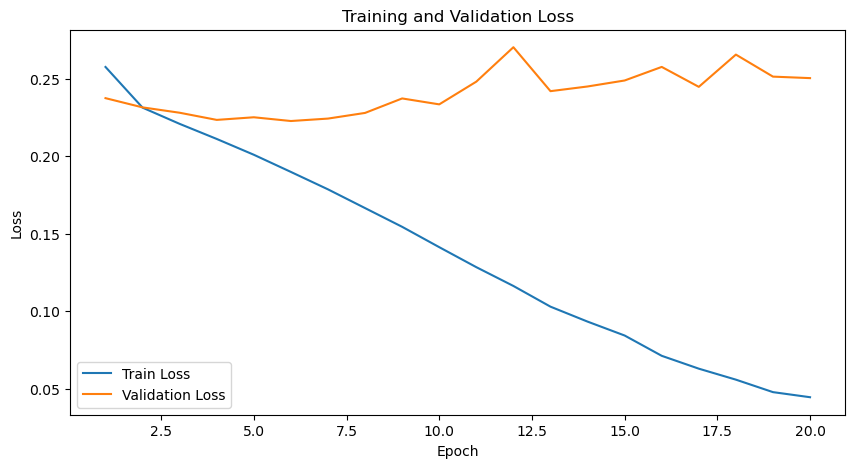

In [339]:
test_loss, test_accuracy = test_model(model, test_loader, criterion, device)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Feature batch shape: torch.Size([32, 1, 128, 128])
Labels batch shape: torch.Size([32])


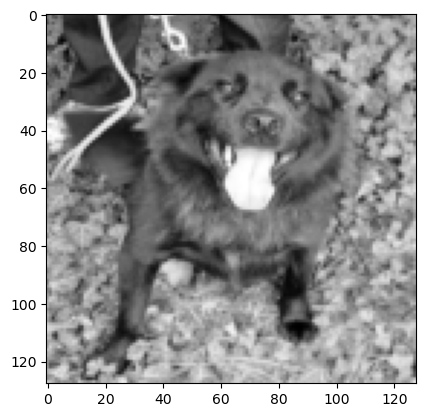

Label: 1


In [311]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")